# Performing Optimal Transport on blades

The goal of this notebook is to understand and visualize the optimal transport problem from a reference measure to a blade and from a blade to another one.

<br>

Authors of this notebook:
* Louis Allain
* Léonard Gousset
* Julien Heurtin

## Regularized Optimal Transport between two blades

This section is dedicated to perform ROT between two cloud points. It is mainly here to help us understand every steps needed to perform ROT using ```jax``` and ```ott``` packages. From here we will determine the best way to carry the ROT problem between two large samples, trading off between memory and time.

In [14]:
import importing
import sinkhorn
import matplotlib.pyplot as plt

# Jax package allows to speed up computation
import jax.numpy as jnp
import jax
import numpy as np

# Packages that actually performs Sinkhorn algorithm
from ott.geometry import pointcloud
from ott.solvers import linear

distributions = importing.r37_blades(ids = [0, 1, 2])

In [6]:
# Start a timer
import time
start_time = time.time()

## First lets take the two first blades
blade_one = distributions[0]
blade_two = distributions[1]

## We need to define the clouds as jax.numpy arrays
cloud_one = jnp.array(blade_one)
cloud_two = jnp.array(blade_two)

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1e-03

geom = pointcloud.PointCloud(cloud_one, cloud_two, epsilon = epsilon, cost_fn = None)
rot_result = linear.solve(geom)

# Stops the timer
end_time = time.time()
time_spent = end_time - start_time
print("Regularized Optimal Transport computation took:", time_spent, "seconds, using epsilon =", epsilon)


## Retrieve left and right potentials
left_potentials = rot_result.f
right_potentials = rot_result.g

## Retrieve the duals potentials
dual_potentials = rot_result.to_dual_potentials()

## Compute the transport plan matrix
transport_plan_matrix = rot_result.matrix

Regularized Optimal Transport computation took: 81.72744607925415 seconds, using epsilon = 0.001


### Plotting the Transport Plan Matrix

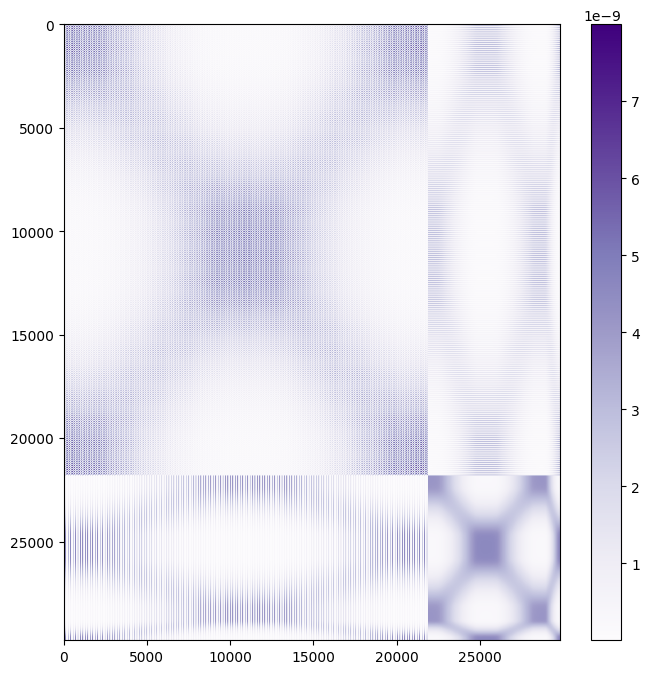

In [9]:
plt.figure(figsize=(8, 8))

# Heatmap visualization of transport plan matrix
plt.imshow(transport_plan_matrix, cmap = "Purples", aspect='auto')
#plt.title('Transport Plan Heatmap\nAgainst another blade')
plt.colorbar()

# Save the figure
#plt.savefig("Images/transport_plan_matrix_blade.png", dpi=100, bbox_inches='tight', format="png")

# Show the figure
plt.show()

### Plotting the Sinkhorn potentials

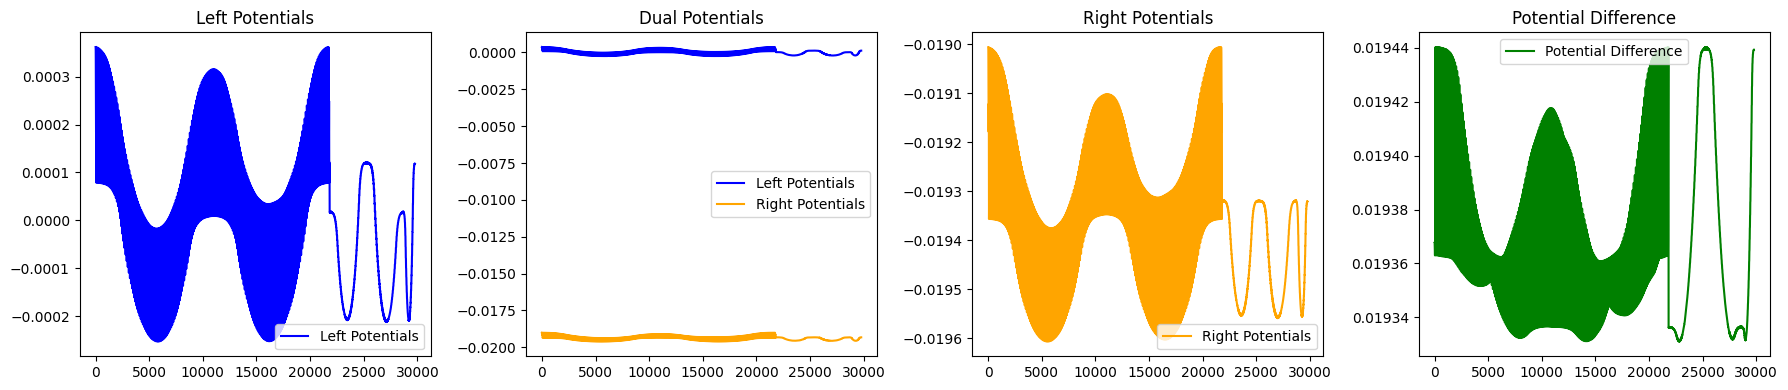

In [10]:
# Define colors for left and right potentials
left_color = 'blue'
right_color = 'orange'

# Calculate the difference between left and right potentials
potential_difference = [left - right for left, right in zip(left_potentials, right_potentials)]

# Plotting the results
plt.figure(figsize=(18, 4))  # Adjust figsize as needed

# Left potentials plot
plt.subplot(1, 4, 1)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.legend()
plt.title('Left Potentials')

# Dual potentials plot
plt.subplot(1, 4, 2)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Dual Potentials')

# Right potentials plot
plt.subplot(1, 4, 3)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Right Potentials')

# Potential difference plot
plt.subplot(1, 4, 4)
plt.plot(potential_difference, label='Potential Difference', color='green')
plt.legend()
plt.title('Potential Difference')

plt.tight_layout()

#plt.savefig("Images/transport_plan_matrix_2_blades.png", dpi=300, bbox_inches='tight', format="png")

plt.show()


## Regularized Optimal Transport between a reference measure and a blade

### Performing Regularized Optimal Transport between the blade and the reference measure sample


In [15]:
## We sample from our reference measure.
reference_measure = sinkhorn.define_reference_measure(data = np.array(distributions), ref_measure = "disk", ref_measure_size = 100)


start_time = time.time()

## We need to define the clouds as jax.numpy arrays
cloud_one = jnp.array(blade_one)

## Define the epsilon for Regularized OT - small epsilon = great accuracy = longer time
epsilon = 1e-03

## Actually computing the Sinkhorn algortihm
geom = pointcloud.PointCloud(cloud_one, reference_measure, epsilon = epsilon, cost_fn = None)
rot_result = linear.solve(geom)

# Stops the timer
end_time = time.time()
time_spent = end_time - start_time
print("Regularized Optimal Transport computation took:", time_spent, "seconds, using epsilon =", epsilon, ". With cost: ", rot_result.ent_reg_cost)

## Retrieve left and right potentials
left_potentials = rot_result.f
right_potentials = rot_result.g

## Retrieve the duals potentials
dual_potentials = rot_result.to_dual_potentials()

## Compute the transport plan matrix
transport_plan_matrix = rot_result.matrix

Regularized Optimal Transport computation took: 0.8984849452972412 seconds, using epsilon = 0.001 . With cost:  -0.013040863


### Plot of the transport cost matrix

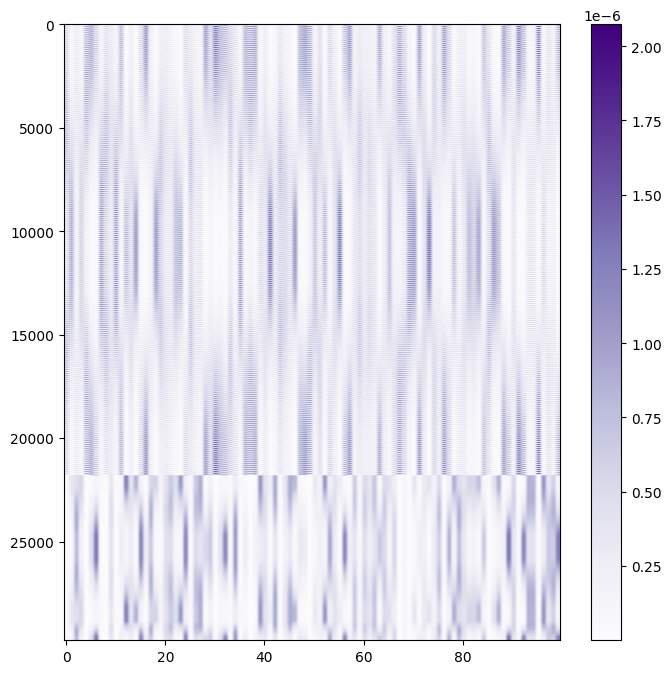

In [16]:
plt.figure(figsize=(8, 8))

# Heatmap visualization of transport plan matrix
plt.imshow(transport_plan_matrix, cmap = "Purples", aspect='auto')
#plt.title('Transport Plan Heatmap\nAgainst another blade')
plt.colorbar()

# Save the figure
#plt.savefig(f"Images/transport_plan_matrix_epsilon_0.001.png", dpi=100, bbox_inches='tight', format="png")
# Show the figure
plt.show()

### Plot of the Sinkhorn potentials

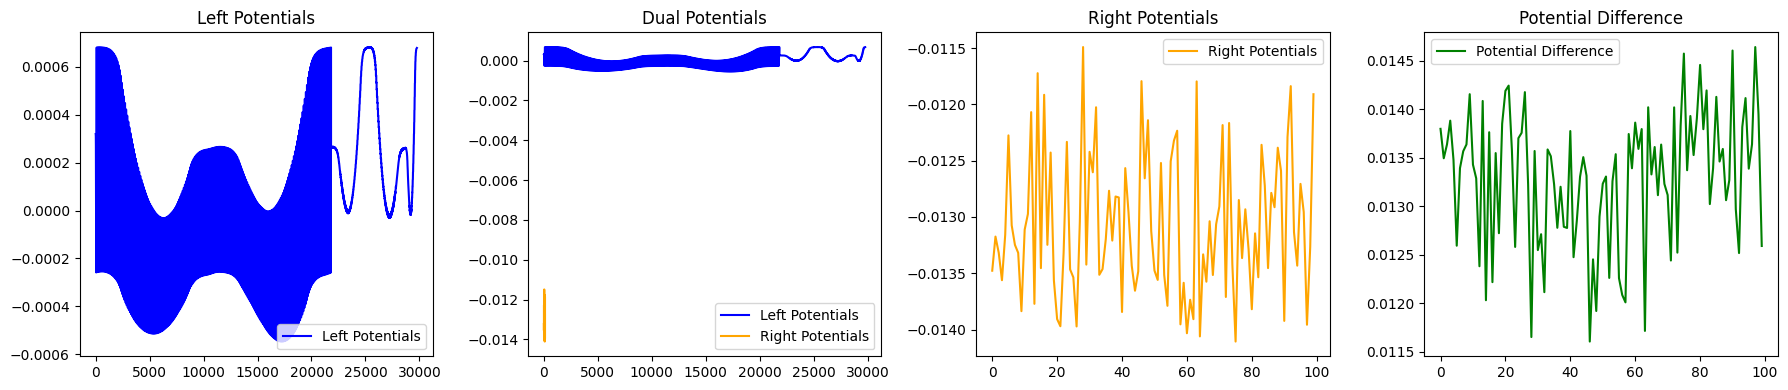

In [17]:
# Define colors for left and right potentials
left_color = 'blue'
right_color = 'orange'

# Calculate the difference between left and right potentials
potential_difference = [left - right for left, right in zip(left_potentials, right_potentials)]

# Plotting the results
plt.figure(figsize=(18, 4))  # Adjust figsize as needed

# Left potentials plot
plt.subplot(1, 4, 1)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.legend()
plt.title('Left Potentials')

# Dual potentials plot
plt.subplot(1, 4, 2)
plt.plot(left_potentials, label='Left Potentials', color=left_color)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Dual Potentials')

# Right potentials plot
plt.subplot(1, 4, 3)
plt.plot(right_potentials, label='Right Potentials', color=right_color)
plt.legend()
plt.title('Right Potentials')

# Potential difference plot
plt.subplot(1, 4, 4)
plt.plot(potential_difference, label='Potential Difference', color='green')
plt.legend()
plt.title('Potential Difference')

plt.tight_layout()

#plt.savefig("Images/transport_plan_matrix_2_blades.png", dpi=300, bbox_inches='tight', format="png")

plt.show()
